# SPEI计算

使用`climate-indices`库直接进行计算。

<https://climate-indices.readthedocs.io/en/latest/index.html#spei-monthly>

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
from climate_indices import compute, indices, utils
import multiprocessing as mp
import numba as nb
import rasterio
import rioxarray as rxr

/home/zyzh0/anaconda3/envs/gis/lib/python3.9/site-packages/climate_indices/utils.py:149: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def reshape_to_2d(
/home/zyzh0/anaconda3/envs/gis/lib/python3.9/site-packages/climate_indices/utils.py:199: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def reshape_to_divs_years_months(
/home/zyzh0/anaconda3/envs/gis/lib/python

文档有点少，先进行测试计算

In [3]:
test_pet_frame = xr.open_dataset('../../outputs/pet-resampled/2000_01.tif').squeeze("band",drop=True)
test_precip_frame = xr.open_dataset('../../outputs/precip-cutted/_2000_2002_1.tif').squeeze("band",drop=True)

In [4]:
test_pet_frame

<xarray.Dataset>
Dimensions:      (x: 840, y: 960)
Coordinates:
  * x            (x) float64 114.0 114.0 114.0 114.0 ... 121.0 121.0 121.0 121.0
  * y            (y) float64 40.0 39.99 39.98 39.97 ... 32.03 32.02 32.01 32.0
    spatial_ref  int64 ...
Data variables:
    band_data    (y, x) float32 ...

In [5]:
test_precip_frame

<xarray.Dataset>
Dimensions:      (x: 840, y: 960)
Coordinates:
  * x            (x) float64 114.0 114.0 114.0 114.0 ... 121.0 121.0 121.0 121.0
  * y            (y) float64 40.0 39.99 39.98 39.97 ... 32.03 32.02 32.01 32.0
    spatial_ref  int64 ...
Data variables:
    band_data    (y, x) float32 ...

这个库文档太少，这里使用手动计算测试

## SPEI计算方法

### 收集相关数据

这里需要逐月降水$P_i$和潜在蒸散发$PET_i$的数据。本节讨论的是单个栅格的情况。

### 计算差值序列

$$ D_i=P_i-PET_i $$

### 将序列推广到时间尺度

$$ D_n^k=\sum_{i=0}^{k-1}(P_{n-i}-PET_{n-i}),\quad n\ge k $$

### 对${D_n^K}$进行正态化

通常认为该差值$D$服从三参数Log-logisitic分布，又称[Fisk分布](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisk.html#scipy-stats-fisk)。

$$ f(x;\kappa,\mu,\lambda)=\frac{\lambda\kappa[\lambda(x-\mu)]^{\kappa-1}}{[1+\lambda^\kappa(x-\mu)^\kappa]^2} $$

其中，$\kappa, \lambda, \mu$分别为形状、尺度和起始参数。对其进行参数估计以得到相关参数。将其带入分布函数

$$ F(x;\kappa,\mu,\lambda)=(1+[\lambda(x-\mu)^\kappa])^{-1} $$

得到序列的概率分布。概率分布函数带入对应$D_i$的值就得到标准化处理之前的SPEI值。

之后进行正态标准化处理，

$$ P=1-F(X) $$

带入标准化计算式，即得SPEI。


先进行数据可视化来验证计算结果

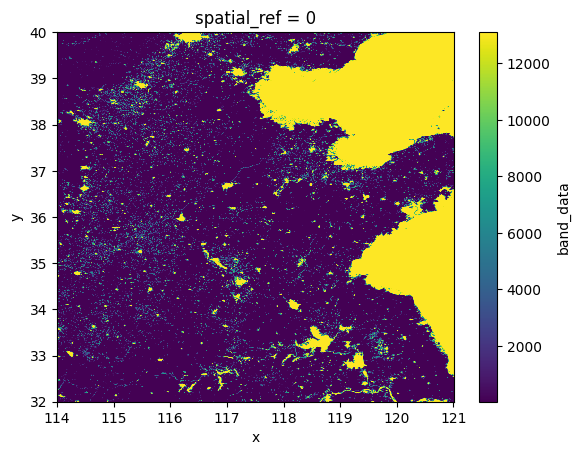

In [6]:
test_pet_frame.band_data.plot()

PET图中过高的部分是由于水域覆盖引起的。

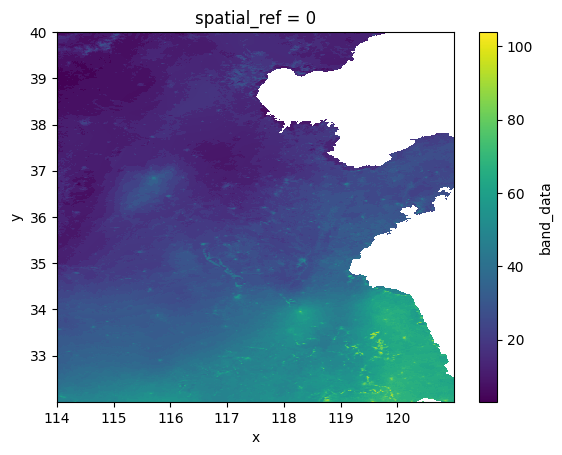

In [7]:
(test_precip_frame.band_data*0.1).plot()

可以使用`scipy`中的`scipy.stats.rv_continuous.fit`进行参数估计

运算量过大，重采样到分辨率的十分之一后再构建差值序列

In [8]:
@nb.jit(parallel=True)
def read_precip():
    filename_lst = []
    base_dir = "../../outputs/precip-cutted/"
    for i in range(0,6):
        year = 2000 + i*3
        for j in range(1,37):
            month = j
            filename_lst.append(base_dir + "_" + str(year) + "_" +str(year+2)+"_"+ str(month) + ".tif")
    filename_lst = filename_lst[0:192]
    
    data_frame = []
    for i in filename_lst:
        print(i)
        test_precip_frame = xr.open_dataset(i).squeeze("band",drop=True)
        test_precip_frame_resampled = test_precip_frame.rio.reproject(test_precip_frame.rio.crs,shape=(96,84),resampling=rasterio.enums.Resampling.bilinear)
        data_frame.append((test_precip_frame_resampled.band_data*0.1).to_numpy())
    return np.array(data_frame)

precip_monthly_mat=read_precip()

../../outputs/precip-cutted/_2000_2002_1.tif
../../outputs/precip-cutted/_2000_2002_2.tif
../../outputs/precip-cutted/_2000_2002_3.tif
../../outputs/precip-cutted/_2000_2002_4.tif
../../outputs/precip-cutted/_2000_2002_5.tif
../../outputs/precip-cutted/_2000_2002_6.tif
../../outputs/precip-cutted/_2000_2002_7.tif
../../outputs/precip-cutted/_2000_2002_8.tif
../../outputs/precip-cutted/_2000_2002_9.tif
../../outputs/precip-cutted/_2000_2002_10.tif
../../outputs/precip-cutted/_2000_2002_11.tif
../../outputs/precip-cutted/_2000_2002_12.tif
../../outputs/precip-cutted/_2000_2002_13.tif
../../outputs/precip-cutted/_2000_2002_14.tif
../../outputs/precip-cutted/_2000_2002_15.tif
../../outputs/precip-cutted/_2000_2002_16.tif
../../outputs/precip-cutted/_2000_2002_17.tif
../../outputs/precip-cutted/_2000_2002_18.tif
../../outputs/precip-cutted/_2000_2002_19.tif
../../outputs/precip-cutted/_2000_2002_20.tif
../../outputs/precip-cutted/_2000_2002_21.tif
../../outputs/precip-cutted/_2000_2002_22.t

In [9]:
@nb.jit(parallel=True)
def read_pet():
    filename_lst = []
    base_dir = "../../outputs/pet-resampled/"
    for i in range(2000,2016):
        year = i
        for j in range(1,13):
            month = j
            filename_lst.append(base_dir + str(year) + "_" + str(month).zfill(2) + ".tif")

    data_frame = []
    for i in filename_lst:
        print(i)
        test_pet_frame = xr.open_dataset(i).squeeze("band",drop=True)
        test_pet_frame_resampled = test_pet_frame.rio.reproject(test_pet_frame.rio.crs,shape=(96,84),resampling=rasterio.enums.Resampling.bilinear)
        data_frame.append(test_pet_frame_resampled.band_data.to_numpy())
    return np.array(data_frame)

pet_monthly_mat=read_pet()

../../outputs/pet-resampled/2000_01.tif
../../outputs/pet-resampled/2000_02.tif
../../outputs/pet-resampled/2000_03.tif
../../outputs/pet-resampled/2000_04.tif
../../outputs/pet-resampled/2000_05.tif
../../outputs/pet-resampled/2000_06.tif
../../outputs/pet-resampled/2000_07.tif
../../outputs/pet-resampled/2000_08.tif
../../outputs/pet-resampled/2000_09.tif
../../outputs/pet-resampled/2000_10.tif
../../outputs/pet-resampled/2000_11.tif
../../outputs/pet-resampled/2000_12.tif
../../outputs/pet-resampled/2001_01.tif
../../outputs/pet-resampled/2001_02.tif
../../outputs/pet-resampled/2001_03.tif
../../outputs/pet-resampled/2001_04.tif
../../outputs/pet-resampled/2001_05.tif
../../outputs/pet-resampled/2001_06.tif
../../outputs/pet-resampled/2001_07.tif
../../outputs/pet-resampled/2001_08.tif
../../outputs/pet-resampled/2001_09.tif
../../outputs/pet-resampled/2001_10.tif
../../outputs/pet-resampled/2001_11.tif
../../outputs/pet-resampled/2001_12.tif
../../outputs/pet-resampled/2002_01.tif


需要对nan值进行预处理

In [61]:
d_monthly_mat = precip_monthly_mat - pet_monthly_mat
d_monthly_mat.shape

(192, 96, 84)

In [60]:
d_3month_mat = np.array([np.sum(d_monthly_mat[i:i+3],axis=0) for i in range(0,192,3)])
d_3month_mat.shape

(64, 96, 84)

In [24]:

def get_fisk_dist_para(d_dis):  
    d_dis = d_dis[~np.isnan(d_dis)]
    if len(d_dis) == 0:
        return np.nan
    para = sp.stats.fisk.fit(d_dis)
    return para


def get_p_value(d_dis, para):
    p_value = 1-sp.stats.fisk.cdf(d_dis, *para)
    return p_value

def standardize_p(p):
    spei_lst = []
    c0,c1,c2,d1,d2,d3 = 2.515517,0.802853,0.010328,1.432788,0.189269,0.001308
    for i in p:
        if i <= 0.5:
            w = np.sqrt(-2*np.log(i))
            spei = w - (c0+c1*w+c2*(w**2))/(1+d1*w+d2*(w**2)+d3*(w**3))
        elif i > 0.5:
            w = np.sqrt(-2*np.log(1-i))
            spei = -(w - (c0+c1*w+c2*(w**2))/(1+d1*w+d2*(w**2)+d3*(w**3)))
        spei_lst.append(spei)
    return np.array(spei_lst)


In [23]:

def calc_spei(d_dis):

        para = get_fisk_dist_para(d_dis)
        if para is np.nan:
            return np.nan

        p = get_p_value(d_dis, para)
        spei = standardize_p(p)

        return spei

SPEI计算方式定义完成。接下来计算逐月份SPEI指数。

In [14]:
print(d_monthly_mat[0,:,:].shape)
print(d_monthly_mat.shape)
print(len(d_monthly_mat[:,0,0]))

(96, 84)
(192, 96, 84)
192


In [15]:
lat=96

In [16]:
lon=84

In [17]:
monthly_spei_mat = np.empty_like(d_monthly_mat)

multi_paras = []

In [18]:
for i in range(lat):
    for j in range(lon):
        multi_paras.append([i,j])
#print(multi_paras)

In [26]:
pool = mp.Pool(processes=mp.cpu_count())

multi_results = pool.map(calc_spei,[d_monthly_mat[:,i,j] for i,j in multi_paras])


array([[[ 1.0075079 ,  1.0227146 ,  1.0228549 , ...,         nan,
                 nan,         nan],
        [ 1.0235969 ,  1.0181253 ,  1.0189909 , ...,         nan,
                 nan,         nan],
        [ 0.98989266,  1.002167  ,  1.0051607 , ...,         nan,
                 nan,         nan],
        ...,
        [ 0.96338886,  0.97119385,  0.97233474, ...,  1.035395  ,
          1.0426581 ,  1.0087584 ],
        [ 0.91356474,  0.73130935,  0.98037565, ...,  0.99821603,
          0.8677674 ,  1.0089926 ],
        [ 0.9567012 ,  0.87090504,  0.9331922 , ...,         nan,
          0.9347303 ,  0.9987741 ]],

       [[ 1.0065581 ,  1.0081397 ,  1.0070058 , ...,         nan,
                 nan,         nan],
        [ 1.0056696 ,  1.0034199 ,  1.0013452 , ...,         nan,
                 nan,         nan],
        [ 0.9852013 ,  1.0176184 ,  1.0443571 , ...,         nan,
                 nan,         nan],
        ...,
        [ 1.0963616 ,  1.001055  ,  0.95094836, ...,  

In [40]:
for i in range(lat):
    for j in range(lon):
        monthly_spei_mat[:,lat-i-1,j] = multi_results[i*lon+j]

monthly_spei_mat

array([[[ 0.9567012 ,  0.87090504,  0.9331922 , ...,         nan,
          0.9347303 ,  0.9987741 ],
        [ 0.91356474,  0.73130935,  0.98037565, ...,  0.99821603,
          0.8677674 ,  1.0089926 ],
        [ 0.96338886,  0.97119385,  0.97233474, ...,  1.035395  ,
          1.0426581 ,  1.0087584 ],
        ...,
        [ 0.98989266,  1.002167  ,  1.0051607 , ...,         nan,
                 nan,         nan],
        [ 1.0235969 ,  1.0181253 ,  1.0189909 , ...,         nan,
                 nan,         nan],
        [ 1.0075079 ,  1.0227146 ,  1.0228549 , ...,         nan,
                 nan,         nan]],

       [[ 1.0304307 ,  1.0032154 ,  0.9609874 , ...,         nan,
          1.338138  ,  1.099575  ],
        [ 1.288503  ,  1.0201607 ,  0.9913052 , ...,  1.0097715 ,
          0.77293265,  0.9913766 ],
        [ 1.0963616 ,  1.001055  ,  0.95094836, ...,  1.0217862 ,
          0.99503773,  1.0312831 ],
        ...,
        [ 0.9852013 ,  1.0176184 ,  1.0443571 , ...,  

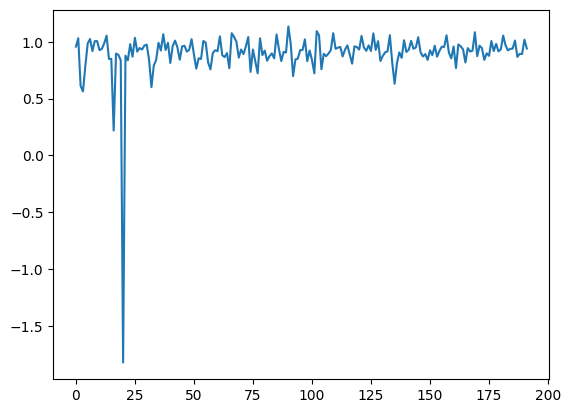

In [53]:
t=monthly_spei_mat[:,0,0]
plt.plot(t)

In [42]:
monthly_spei = monthly_spei_mat.copy()

In [43]:
monthly_spei.shape

(192, 96, 84)

In [44]:
test_pet_frame = xr.open_dataset('../../outputs/pet-resampled/2000_10.tif').squeeze("band",drop=True)
test_pet_frame_resampled = test_pet_frame.rio.reproject(test_pet_frame.rio.crs,shape=(96,84),resampling=rasterio.enums.Resampling.bilinear)


In [45]:
month = np.array([i for i in range(1,193)])

latArr = sorted(test_pet_frame_resampled.coords['y'])
lonArr = sorted(test_pet_frame_resampled.coords['x'])



In [46]:
spei_frame = xr.Dataset(
 data_vars = {
        'spei':(['month','y','x'],monthly_spei)
 },
 coords={
        'x': (['x'], lonArr),
        'y': (['y'], latArr),
        'month':month
 }
)

In [47]:
spei_frame.rio.write_crs(4326, inplace=True).rio.set_spatial_dims(x_dim="x",y_dim="y",inplace=True).rio.write_coordinate_system(inplace=True)

<xarray.Dataset>
Dimensions:      (month: 192, y: 96, x: 84)
Coordinates:
  * x            (x) float64 114.0 114.1 114.2 114.3 ... 120.7 120.8 120.9 121.0
  * y            (y) float64 32.04 32.12 32.21 32.29 ... 39.71 39.8 39.88 39.96
  * month        (month) int64 1 2 3 4 5 6 7 8 ... 186 187 188 189 190 191 192
    spatial_ref  int64 0
Data variables:
    spei         (month, y, x) float32 0.9567 0.8709 0.9332 ... nan nan nan

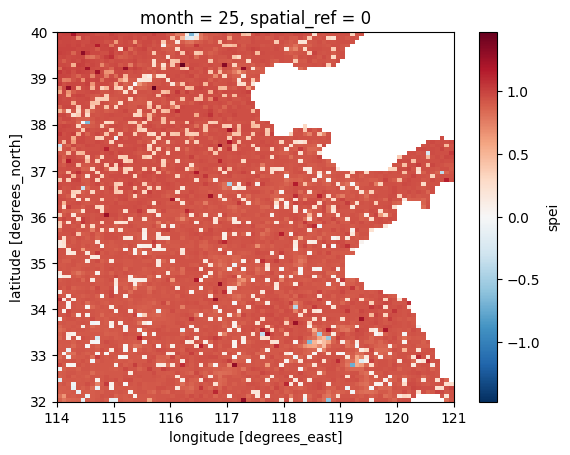

In [56]:
spei_frame.loc[dict(month=25)].spei.plot()

保存数据到netcdf文件

In [49]:
spei_frame.to_netcdf("./spei_monthly_2000_2015.nc")

In [62]:
month3_spei_mat = np.empty_like(d_3month_mat)

pool = mp.Pool(processes=mp.cpu_count())

multi_results = pool.map(calc_spei,[d_3month_mat[:,i,j] for i,j in multi_paras])

In [63]:
for i in range(lat):
    for j in range(lon):
        month3_spei_mat[:,lat-i-1,j] = multi_results[i*lon+j]
        

In [64]:
month3_spei_mat.shape

(64, 96, 84)

In [65]:
spei3_frame = xr.Dataset(
    data_vars = {
        'spei':(['month','y','x'],month3_spei_mat)

    },
    coords={
        'x': (['x'], lonArr),
        'y': (['y'], latArr),

        'month':np.array([i for i in range(1,65)])
    }
)

In [66]:
spei3_frame.rio.write_crs(4326, inplace=True).rio.set_spatial_dims(x_dim="x",y_dim="y",inplace=True).rio.write_coordinate_system(inplace=True)

<xarray.Dataset>
Dimensions:      (month: 64, y: 96, x: 84)
Coordinates:
  * x            (x) float64 114.0 114.1 114.2 114.3 ... 120.7 120.8 120.9 121.0
  * y            (y) float64 32.04 32.12 32.21 32.29 ... 39.71 39.8 39.88 39.96
  * month        (month) int64 1 2 3 4 5 6 7 8 9 ... 56 57 58 59 60 61 62 63 64
    spatial_ref  int64 0
Data variables:
    spei         (month, y, x) float32 0.9396 0.9061 0.8517 ... nan nan nan

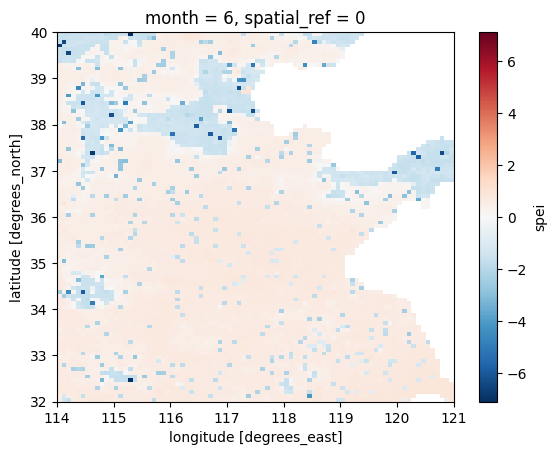

In [73]:
spei3_frame.loc[dict(month=6)].spei.plot()

In [74]:
spei3_frame.to_netcdf("./spei_3month_2000_2015.nc")